In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
import time
import cmath

import keras
import keras.layers as layers
from keras import backend as K
from keras.utils import plot_model
from keras import regularizers
from keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


TODO
* Back to cqt
* Pull unused octave at the bottom from NN inputs

* Add regularizers and drop out

* Use callbacks for LR reduction and to save best models with error info

* Tensorboard?
* Automatic logging of graphs, errors, models etc. for comparison

* Add graph of model
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
* Create log output function, then capture to text file (also export graphs?)

* Look for sources of noise that are close to what I want?  Or generate some clips?

* Debugging tools for comparing, listening to, and viewing clips
* Add audio quality comparisons between clean clips and cleaned clips for evaluation

* Add history error plotting to compare different learning models, topologies, etc.

* Look into streaming frames to & from file and having way more samples

* Why does https://towardsdatascience.com/audio-ai-isolating-vocals-from-stereo-music-using-convolutional-neural-networks-210532383785 only use real component?
* Evaluate different representations of complex numbers in terms of learnability

* Consider generating custom data for goal - male speakers, low voice, specific sounds

In [2]:
# Constants and settings
WINDOW_SIZE = 25  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

DTYPE = 'float32'

# cqt related
FFT_BINS = 768 # function of items below
HOP_LENGTH = 128 # Required for good cqt results

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048

# cqt values
BINS_PER_OCTAVE = 12 * 8
FMIN = librosa.note_to_hz('C1')
OCTAVES = 8

In [3]:
# Idea here is that we operate on magnitude, and will just use phase from the original noisy sample

#def combine_target(t):
#    return (t[0:t.shape[0]//2] + 1j * t[t.shape[0]//2:]).reshape(1,(t.shape[0]//2))

def rebuild_fft(output, original_fft):
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = output.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)
    
# build up as (bins, samples) then transpose to model view of (samples, bins)
#def targets_to_fft(targets):
#    fft = np.empty((targets.shape[0],targets.shape[1]//2), dtype='complex64')
#    for i in range(0, targets.shape[0]):
#        fft[i] = combine_target(targets[i])
#    return fft.T   # transpose

# May not actually use this - may want to just pass a reduced view and then add this back to get right shape
def filter(cqt):
    cqt[0:BINS_PER_OCTAVE,:] = 0
    return cqt

def get_ft(wav):
    c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    #c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    return librosa.icqt(ft, hop_length=HOP_LENGTH, fmin=FMIN, bins_per_octave=BINS_PER_OCTAVE)
    #return librosa.istft(ft, hop_length=HOP_LENGTH)
    

In [4]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
print(fft.shape)

(768, 477)


In [5]:
# Creating data from clip wave file
# Optimization - does frames for each clip in preallocated array
# output is (samples, bins, window size, 1), where image is magnitude of complex values
def clip_frames(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav) # organized as bins, frames
    bins = fft.shape[0]
    pad = np.zeros((bins,frame_lead))
    frames = np.empty(shape=(fft.shape[1],bins,WINDOW_SIZE,1)) 
    fft = np.concatenate([pad, fft, pad], axis=-1)
    for i in range(0, fft.shape[1] - WINDOW_SIZE + 1):
        frames[i,:,:,0] = abs(fft[:,i:i+WINDOW_SIZE])
    return frames

# output is array (samples, bin length magnitues)
def clip_targets(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav)
    bins = fft.shape[0]
    targets = np.empty(shape=(fft.shape[1],fft.shape[0]))
    for i in range(0, fft.shape[1]):
        targets[i,:] = abs(fft[:,i:i+1]).flatten()
    return targets

In [10]:
# Iterate over clean & noisy folders to create frames and targets
def create_data(root, max_files = 50):
    clean_dir = root + "\\Clean\\"
    noisy_dir = root + "\\Noisy\\"
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,1))
    targets = np.empty(shape=(0,FFT_BINS))
    i = 0
    start = time.time()
    check = time.time()
    for file in os.listdir(clean_dir)[0:max_files]:
        i += 1
        if i % 50 == 0:
            print("{0} clips   total {1:.0f}   last cycle {2:.0f}".format(i, time.time() - start,time.time()-check))
            check = time.time()
        filename = os.fsdecode(file)
        frames = np.concatenate((frames,clip_frames(noisy_dir + file)), axis=0)
        targets = np.concatenate((targets,clip_targets(clean_dir + file)), axis=0)
    return frames, targets


In [11]:
#frames, targets = create_data("Assets\\DataShareArchive\\test", 50)

50 clips   total 1731   last cycle 1731


In [6]:
def get_frames(data_path, samples):
    frames_file = data_path + "\\frames-" + str(samples)
    filename = os.fsdecode(frames_file)
    return np.memmap(filename, mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, WINDOW_SIZE, 1))

def get_targets(data_path, samples):
    targets_file = data_path + "\\targets-" + str(samples)
    filename = os.fsdecode(targets_file)
    return np.memmap(filename, mode='r', dtype=DTYPE, shape=(samples, FFT_BINS))


In [7]:
frames = get_frames("f:\\audiodata", 100000)
targets = get_targets("f:\\audiodata", 100000)

In [16]:
# Will only verify clean vs clean!
i = 10
print(frames[i,0, 12:13, 0])
print(targets[i,0])

[0.00775779]
0.022335141897201538


In [62]:
# Real model (eventually)
ALPHA = 0.05
L2Reg = 0.00000 # bumping this up to 0.000005 didn't seem very good

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,1)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,1)) # Just the center row that we're trying to predict

# Broad bins
conv1 = layers.Conv2D(256, kernel_size=(BINS_PER_OCTAVE//2,5), strides=(8,2), activity_regularizer=regularizers.l2(L2Reg), name="conv1")(inputs)
c1a = layers.LeakyReLU(alpha=ALPHA)(conv1)
conv2 = layers.Conv2D(128, kernel_size=(5,2), strides=(2,1), activity_regularizer=regularizers.l2(L2Reg), name="conv2")(c1a)
c2a = keras.layers.LeakyReLU(alpha=ALPHA)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2,2))(c2a)
p2a = layers.LeakyReLU(alpha=ALPHA)(pool2)

conv3 = layers.Conv2D(64, kernel_size=(2,2), activity_regularizer=regularizers.l2(L2Reg), name="conv3")(p2a) 
c3a = layers.LeakyReLU(alpha=ALPHA)(conv3)
#conv4 = layers.Conv2D(48, kernel_size=(FFT_BINS-4,1), activity_regularizer=regularizers.l2(L2Reg), name="conv4")(c3a)
#c4a = layers.LeakyReLU(alpha=ALPHA)(conv4)
flat = layers.Flatten(name="flat")(c3a)

#flat = layers.concatenate([flat])

flat_in = layers.Flatten()(input_slice)

dense0 = layers.Dense(500, activity_regularizer=regularizers.l2(L2Reg))(flat)
d0a = layers.LeakyReLU(alpha=ALPHA)(dense0)
#merge1 = layers.concatenate([d0a, flat_in])
dense1 = layers.Dense(200, activity_regularizer=regularizers.l2(L2Reg))(d0a)
d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
#dense2 = layers.Dense(500, )(dense1)
#d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
merged = layers.concatenate([d1a, flat_in])
outputs = layers.Dense(FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 768, 25, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 91, 11, 256)  61696       input_29[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_69 (LeakyReLU)      (None, 91, 11, 256)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 44, 10, 128)  327808      leaky_re_lu_69[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [ ]:
stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint("Best_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

hist = model.fit([frames, frames[:,:,TARGET_COL:TARGET_COL+1,:]], targets, epochs=5, callbacks = [stopper, save_best], batch_size=32, validation_split=0.05)

Train on 95000 samples, validate on 5000 samples
Epoch 1/5
95000/95000 [==============================] - 205s 2ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 2/5
95000/95000 [==============================] - 197s 2ms/step - loss: 9.1355e-04 - val_loss: 0.0020
Epoch 3/5
95000/95000 [==============================] - 197s 2ms/step - loss: 7.1746e-04 - val_loss: 0.0020
Epoch 4/5
95000/95000 [==============================] - 197s 2ms/step - loss: 6.6044e-04 - val_loss: 0.0020
Epoch 5/5
52192/95000 [===============>..............] - ETA: 8:13 - loss: 6.6597e-04

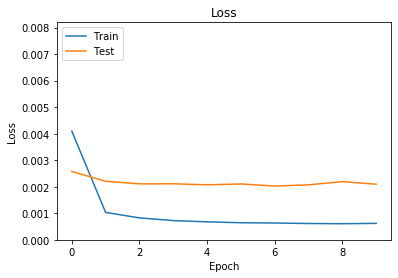

Validation loss mean 5+ epochs 0.002098
Lowest validation loss 0.002026
Frames  100000


In [41]:

history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 2 * history.history['loss'][0])) # because sometimes there are stupid spikes in error
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Lowest validation loss {0:.4}".format(np.min(history.history['val_loss'][5:])))
print("Frames ", frames.shape[0])


In [42]:
# Not required because of 'restore best weights'
#model = keras.models.load_model("Best_model.h5")

Cleaned clip
Average abs err vs clean =  0.016840044301449503


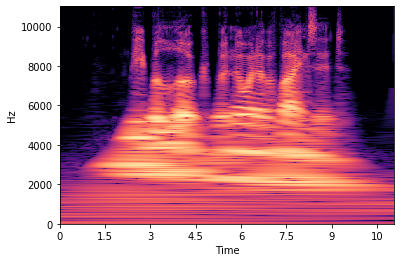

In [53]:
# Full round trip test
file = "p232_015.wav"

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file

def clean_clip(model, n_file):
    verify_frames = clip_frames(n_file)
    output_targets = model.predict([verify_frames, verify_frames[:,:,TARGET_COL:TARGET_COL+1,:]])
    wav, rate = librosa.core.load(n_file)
    n_fft = get_ft(wav)
    fft = rebuild_fft(output_targets, n_fft)
    return fft, inv_ft(fft)

p_fft, p_wav = clean_clip(model, verify_file)
    
wav, rate = librosa.core.load(clean_file)
c_fft = get_ft(wav)


def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='linear', x_axis='time')

print("Cleaned clip")

err_fft = c_fft - p_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

display_fft(p_fft)
Audio(p_wav,rate=22050)


In [54]:
def draw(wav):
    fft = get_ft(wav)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='linear', x_axis='time')
    return fft

Noisy file


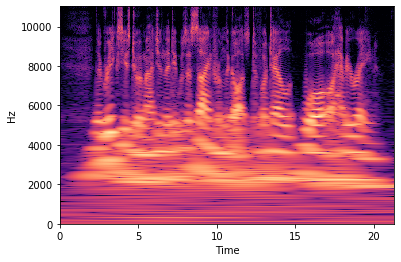

In [55]:
wav, rate = librosa.core.load(verify_file)
n_fft = draw(wav)

print("Noisy file")
Audio(wav, rate=rate)

Clean sample, round trip


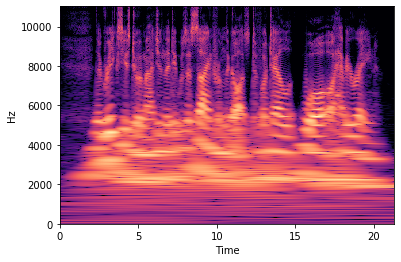

In [56]:
wav, rate = librosa.core.load(clean_file)

c_fft = draw(wav)

print("Clean sample, round trip")

Audio(inv_ft(c_fft), rate=rate)

Removed audio
Average cut value =  0.017835066518470732


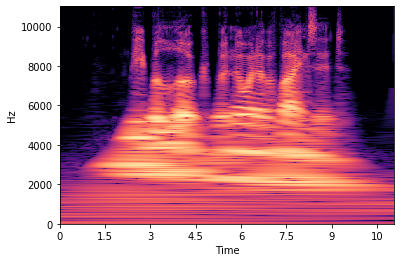

In [57]:
cut_fft = n_fft-p_fft
display_fft(cut_fft)

print("Removed audio")
print("Average cut value = ", np.mean(abs(cut_fft)))

cut_wav = inv_ft(cut_fft)
Audio(cut_wav,rate=22050)


In [ ]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


In [ ]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

(120, 513, 25, 1)
(120, 513)
0.002826246665790677
[0.00282625]
(513, 120)


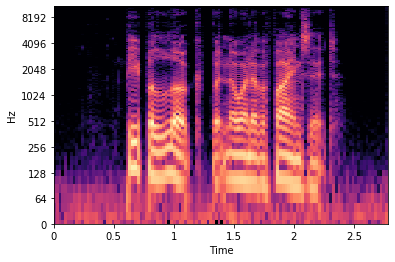

In [6]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  don't use first row because it might be zeroed out
r = 10
print(tt[0,r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0])

# Round trip test
new_fft = rebuild_fft(tt, fft)
print(new_fft.shape)
new_wav = inv_ft(new_fft)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

Audio(new_wav,rate=22050)

In [ ]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [ ]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


In [ ]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)

In [67]:
t = layers.Input(shape=(10,))
t1 = layers.Dense(100)(t)
o = keras.layers.LeakyReLU(alpha=0.3)(t1)
m = keras.models.Model(inputs=t, outputs=o)

In [55]:
# Real model (eventually)
ALPHA = 0.05

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,1)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,1)) # Just the center row that we're trying to predict

# Horizontal features - across bins
conv1 = layers.Conv2D(256, kernel_size=(FFT_BINS,3))(inputs)
c1a = keras.layers.LeakyReLU(alpha=ALPHA)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1,6), strides=(1,3))(c1a)
p1a = keras.layers.LeakyReLU(alpha=ALPHA)(pool1)
flat_h = layers.Flatten()(p1a)

# Vertical features - across samples
conv3 = layers.Conv2D(128, kernel_size=(5,WINDOW_SIZE))(inputs) 
c3a = keras.layers.LeakyReLU(alpha=ALPHA)(conv3)
pool2 = layers.MaxPooling2D(pool_size=(6,1), strides=(3,1))(c3a)
p2a = keras.layers.LeakyReLU(alpha=ALPHA)(pool2)
conv4 = layers.Conv2D(48, kernel_size=(10,1), strides=(3,1))(p2a)
c4a = keras.layers.LeakyReLU(alpha=ALPHA)(conv4)
pool3 = layers.MaxPooling2D(pool_size=(3,1), strides=(2,1))(c4a)
p3a = keras.layers.LeakyReLU(alpha=ALPHA)(pool3)
flat_v = layers.Flatten()(p3a)
#flat = layers.Flatten()(conv4)

flat = layers.concatenate([flat_h, flat_v])

dense0 = layers.Dense(700)(flat)
d0a = keras.layers.LeakyReLU(alpha=ALPHA)(dense0)
#dense1 = layers.Dense(1000)(dense0)
#d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
#dense2 = layers.Dense(500, )(dense1)
#d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
flat_in = layers.Flatten()(input_slice)
merged = layers.concatenate([d0a, flat_in])
outputs = layers.Dense(FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 513, 25, 1)   0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 509, 1, 128)  16128       input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_38 (LeakyReLU)      (None, 509, 1, 128)  0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 168, 1, 128)  0           leaky_re_lu_38[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [8]:
# Real model (eventually)
ALPHA = 0.05
L2Reg = 0.00000 # bumping this up to 0.000005 didn't seem very good

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,1)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,1)) # Just the center row that we're trying to predict

# Horizontal first - across bins then samples
conv1 = layers.Conv2D(256, kernel_size=(FFT_BINS,3), activity_regularizer=regularizers.l2(L2Reg), name="conv1")(inputs)
c1a = layers.LeakyReLU(alpha=ALPHA)(conv1)
convh2 = layers.Conv2D(128, kernel_size=(1,WINDOW_SIZE-2), activity_regularizer=regularizers.l2(L2Reg), name="convh2")(c1a)
ch2a = keras.layers.LeakyReLU(alpha=ALPHA)(convh2)
flat_h = layers.Flatten(name="flat_h")(ch2a)

# Vertical features - across samples then bins
conv3 = layers.Conv2D(64, kernel_size=(5,WINDOW_SIZE), activity_regularizer=regularizers.l2(L2Reg), name="conv3")(inputs) 
c3a = layers.LeakyReLU(alpha=ALPHA)(conv3)
#pool2 = layers.MaxPooling2D(pool_size=(8,1), strides=(4,1))(c3a)
#p2a = layers.LeakyReLU(alpha=ALPHA)(pool2)
conv4 = layers.Conv2D(48, kernel_size=(FFT_BINS-4,1), activity_regularizer=regularizers.l2(L2Reg), name="conv4")(c3a)
c4a = layers.LeakyReLU(alpha=ALPHA)(conv4)
flat_v = layers.Flatten(name="flat_v")(c4a)

flat = layers.concatenate([flat_h, flat_v])

flat_in = layers.Flatten()(input_slice)

dense0 = layers.Dense(500, activity_regularizer=regularizers.l2(L2Reg))(flat)
d0a = layers.LeakyReLU(alpha=ALPHA)(dense0)
merge1 = layers.concatenate([d0a, flat_in])
dense1 = layers.Dense(300, activity_regularizer=regularizers.l2(L2Reg))(merge1)
d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
#dense2 = layers.Dense(500, )(dense1)
#d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
merged = layers.concatenate([d1a, flat_in])
outputs = layers.Dense(FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 25, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1, 23, 256)   590080      input_1[0][0]                    
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 764, 1, 64)   8064        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1, 23, 256)   0           conv1[0][0]                      
__________________________________________________________________________________________________
leaky_